In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score,recall_score,accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings

In [36]:
df = pd.read_csv('data/heart.csv')

In [37]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [38]:
df.loc[449,['RestingBP','Cholesterol']] = np.nan
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = np.nan

In [39]:
df['Cholesterol'] = df['Cholesterol'].fillna(df['Cholesterol'].median())
df['RestingBP'] = df['RestingBP'].fillna(df['RestingBP'].median())

In [40]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [41]:
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N':0,'Y':1})
df['Sex'] = df['Sex'].map({'M':1,'F':0})

In [42]:
from sklearn.preprocessing import TargetEncoder
te = TargetEncoder()
df['ST_Slope'] = te.fit_transform(df[['ST_Slope']],df['HeartDisease'])
df['ChestPainType'] = te.fit_transform(df[['ChestPainType']],df['HeartDisease'])

In [43]:
freq = df["RestingECG"].value_counts(normalize=True)
df["RestingECG"] = df["RestingECG"].map(freq)

In [1]:
df.head(15)

NameError: name 'df' is not defined

In [45]:
X = df.drop(df[['HeartDisease']],axis=1)
y = df['HeartDisease']

In [46]:
from sklearn.preprocessing import Normalizer
norm_values = X.drop(['ChestPainType','ST_Slope','RestingECG'],axis=1)
norm = Normalizer().set_output(transform='pandas')
norm.fit(X.drop(['ChestPainType','ST_Slope','RestingECG'],axis=1))
norm_values = norm.transform(norm_values)




In [47]:
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,0.139304,140.0,289.0,0,0.601307,172,0,0.0,0.217708
1,49,0,0.351505,160.0,180.0,0,0.601307,156,0,1.0,0.817997
2,37,1,0.151482,130.0,283.0,0,0.193900,98,0,0.0,0.196241
3,48,0,0.777942,138.0,214.0,0,0.601307,108,1,1.5,0.828840
4,54,1,0.359142,150.0,195.0,0,0.601307,122,0,0.0,0.183670


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


In [49]:
def compare_models_with_gridsearch(models_with_params, X_train, X_test, y_train, y_test, metric=recall_score):
    """
    Porównuje modele z RandomizedSearchCV na tych samych danych i zwraca najlepszy model z wynikami.
    
    Args:
    - models_with_params (list): Lista krotek (nazwa_modelu, instancja_modelu, parametry).
    - X_train, X_test (array): Dane treningowe i testowe (cechy).
    - y_train, y_test (array): Dane treningowe i testowe (etykiety).
    - metric (function): Funkcja oceny modelu (domyślnie accuracy_score).
    
    Returns:
    - best_model_name (str): Nazwa najlepszego modelu.
    - best_model (object): Instancja najlepszego modelu z optymalnymi hiperparametrami.
    - results (dict): Wyniki najlepszych modeli po RandomizedSearchCV.
    """
    results = {}
    best_model_name = None
    best_model = None
    best_score = float('-inf')
    cv = StratifiedKFold(3)
    
    for name, model, params in models_with_params:
        print(f"Trenuję model: {name}")
        # GridSearchCV
        grid = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='f1', cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        
        # Przewidywanie na zbiorze testowym
        y_pred = grid.best_estimator_.predict(X_test)
        score = metric(y_test, y_pred)
        results[name] = {"Best Params": grid.best_params_, "\nScore": score}
        print('--------------------------------------------')
        print(classification_report(y_pred,y_test))
        print('--------------------------------------------')
        
        # Zaktualizuj najlepszego modela
        if score > best_score:
            best_score = score
            best_model_name = name
            best_model = grid.best_estimator_
    
    return best_model_name, best_model, results


In [ ]:

#Decision tree params
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [3,5,9,15,20]
max_features = ['sqrt','log2']

#Random Forest params
n_estimators = [50,100,200]





penalty = ['l1', 'l2', 'elasticnet',None]
C = [0.01,0.1,1,0.0001,10]
class_weight = ['balanced',None]
solver = [ 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale','auto']


#catboost_params
learning_rate = [0.001,0.01,0.1]

#xgb_params
sampling_method = ['uniform','gradient_based']
lma = [1,2,0.1,1.1]


#gbclassifier
loss = ['log_loss', 'exponential']


params_svc = dict(C=C,kernel=kernel,class_weight=class_weight,gamma=gamma)
params_lr = dict(penalty=penalty,C=C,class_weight=class_weight,solver=solver)
params_dt = dict(criterion=criterion,max_depth=max_depth,max_features=max_features)
params_rf = dict(criterion=criterion,max_depth=max_depth,max_features=max_features,n_estimators=n_estimators)
params_ctb = dict(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate)
params_xgb = dict(max_depth=max_depth,reg_lambda = lma,sampling_method=sampling_method)
params_ada = dict(n_estimators=n_estimators,learning_rate=learning_rate)
params_gbst = dict(loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)




models = [['LogisticRegression',LogisticRegression(),params_lr],
          ['SVMclassifier',SVC(),params_svc],
          ['DecisionTreeClassifier',DecisionTreeClassifier(),params_dt],
          ['RandomForestClaasifier',RandomForestClassifier(),params_rf],
          ['CatBoostClassifier',CatBoostClassifier(),params_ctb],
          ['XGBoostClassifier',XGBClassifier(),params_xgb],
          ['AdaBoostClassifier',AdaBoostClassifier(),params_ada],
          ['GradientBoostingClassifier',GradientBoostingClassifier(),params_gbst]
          ]

name,model, results = compare_models_with_gridsearch(models,X_train,X_test,y_train,y_test)

print(name)
print(model)
print(results)




Trenuję model: LogisticRegression


c:\Users\kuban\Documents\MLProject-1\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kuban\Documents\MLProject-1\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kuban\Documents\MLProject-1\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\kuban\Documents\MLProject-1\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fi

--------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       140
           1       0.83      0.91      0.87       163

    accuracy                           0.85       303
   macro avg       0.86      0.85      0.85       303
weighted avg       0.85      0.85      0.85       303

--------------------------------------------
Trenuję model: SVMclassifier
--------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       135
           1       0.85      0.91      0.88       168

    accuracy                           0.86       303
   macro avg       0.86      0.86      0.86       303
weighted avg       0.86      0.86      0.86       303

--------------------------------------------
Trenuję model: DecisionTreeClassifier
--------------------------------------------
              precision    recall  f1-score   support


In [16]:
y_pred= model.predict(X_test)
f1_score(y_test,y_pred)

0.8944444444444444

In [17]:
from sklearn.metrics import roc_curve,roc_auc_score
dummy_model_prob = [0 for _ in range(len(y_test))]
model_prob = model.predict_proba(X_test)
model_prob = model_prob[:,1]

In [18]:
dummy_model_auc = roc_auc_score(y_test,dummy_model_prob)
model_auc = roc_auc_score(y_test,model_prob)
print(dummy_model_auc)
print(model_auc)

0.5
0.9399728997289972


In [19]:
dummy_fpr,dummy_tpr,_ = roc_curve(y_test,dummy_model_prob)
model_fpr,model_tpr,thresholds = roc_curve(y_test,model_prob)

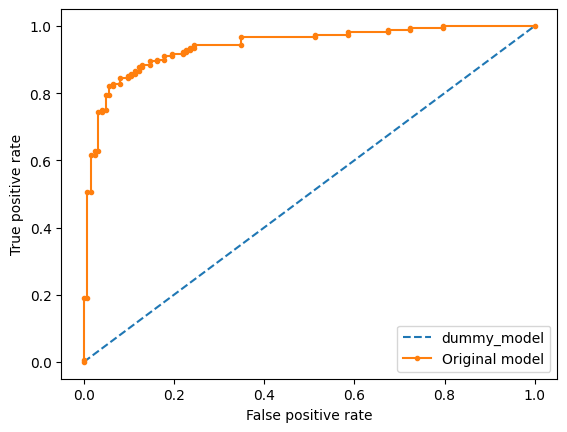

In [20]:
plt.plot(dummy_fpr,dummy_tpr,linestyle = '--',label='dummy_model')
plt.plot(model_fpr,model_tpr,marker='.',label='Original model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

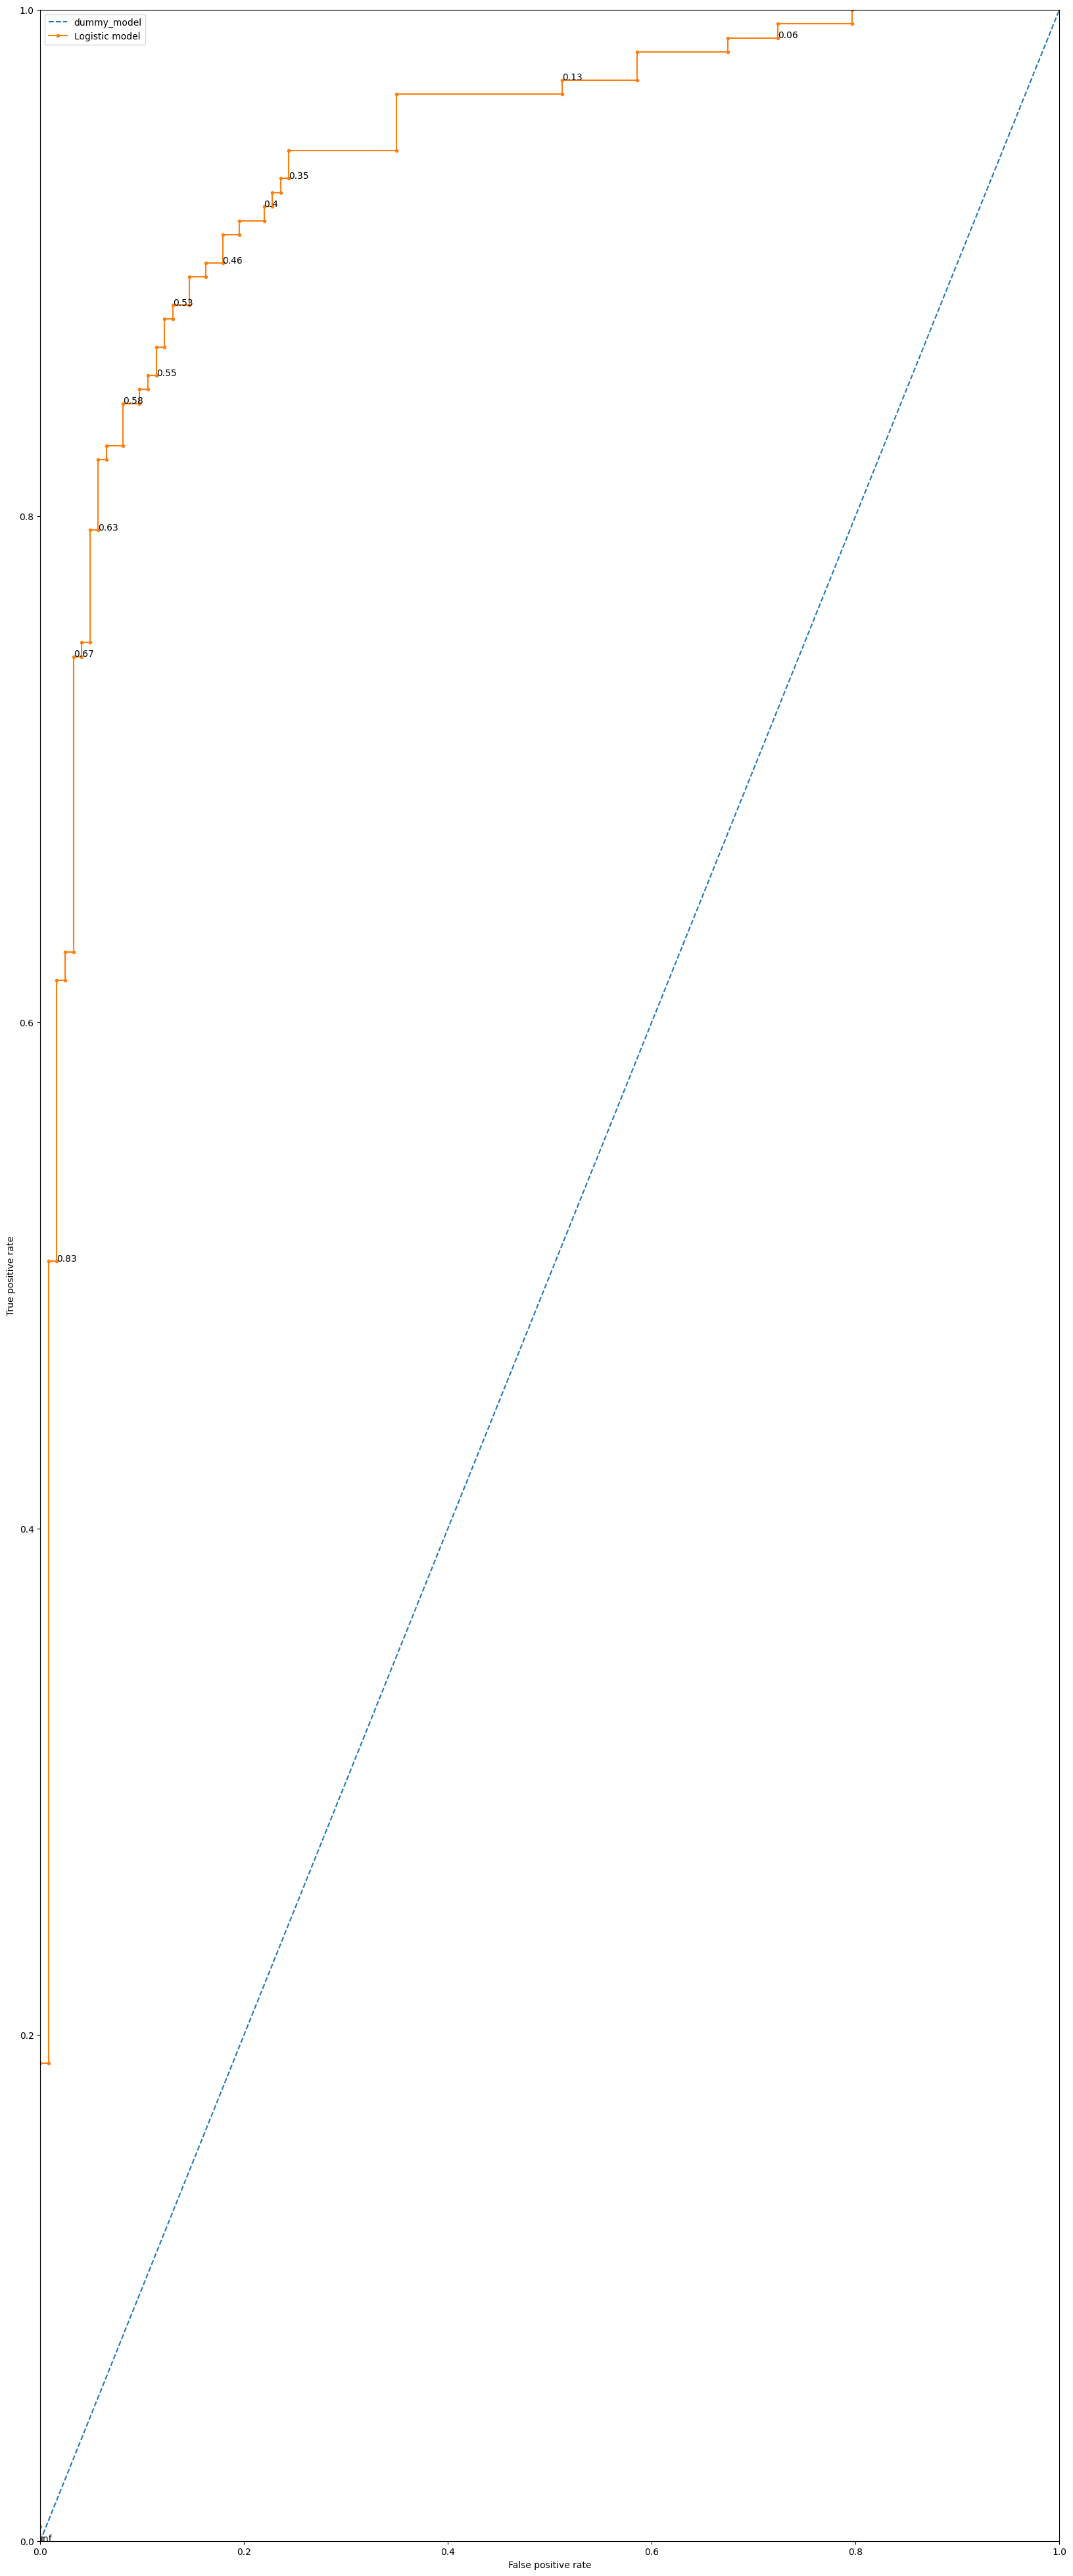

In [21]:
fig = plt.figure(figsize=(20,50))
ax = fig.add_subplot(111)
plt.plot(dummy_fpr,dummy_tpr,linestyle = '--',label='dummy_model')
plt.plot(model_fpr,model_tpr,marker='.',label='Logistic model')

for i, xyz in enumerate(zip(model_fpr, model_tpr, thresholds)):
    if i % 5 == 0:  # Co 5 punkt
        ax.annotate('%s' % np.round(xyz[2], 2), xy=(xyz[0], xyz[1]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [24]:
probas = model.predict_proba(X_test)[:, 1]  # Prawdopodobieństwo klasy 1

# Zmieniamy próg, np. na 0.7
threshold = 0.3
predictions = (probas >= threshold).astype(int)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       123
           1       0.85      0.94      0.89       180

    accuracy                           0.86       303
   macro avg       0.87      0.85      0.86       303
weighted avg       0.87      0.86      0.86       303

